Allison Schlissel  
Project Movie Money  
July 15, 2016  

In [26]:
import pandas as pd
import numpy as np
import matplotlib as plt
%matplotlib inline
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import codecs
import time
import pprint
import re
import requests
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices
import seaborn as sns

### Beautiful Soup URLs

In [4]:
top_urls = ['http://www.boxofficemojo.com/alltime/world/', 'http://www.boxofficemojo.com/alltime/world/?pagenum=2&p=.htm', 'http://www.boxofficemojo.com/alltime/world/?pagenum=3&p=.htm', 'http://www.boxofficemojo.com/alltime/world/?pagenum=4&p=.htm', 'http://www.boxofficemojo.com/alltime/world/?pagenum=5&p=.htm']

my_movies = []
for top_url in top_urls:

    top_soup = BeautifulSoup(requests.get(top_url).text,'lxml')

    for i in top_soup.findAll(href = True):
        if '/movies/?id=' in i['href']:
            url = 'http://www.boxofficemojo.com'+i['href']
            my_movies.append(url)
            print url
           


http://www.boxofficemojo.com/movies/?id=themagnificentseven.htm
http://www.boxofficemojo.com/movies/?id=avatar.htm
http://www.boxofficemojo.com/movies/?id=titanic.htm
http://www.boxofficemojo.com/movies/?id=starwars7.htm
http://www.boxofficemojo.com/movies/?id=jurassicpark4.htm
http://www.boxofficemojo.com/movies/?id=avengers11.htm
http://www.boxofficemojo.com/movies/?id=fast7.htm
http://www.boxofficemojo.com/movies/?id=avengers2.htm
http://www.boxofficemojo.com/movies/?id=harrypotter72.htm
http://www.boxofficemojo.com/movies/?id=frozen2013.htm
http://www.boxofficemojo.com/movies/?id=ironman3.htm
http://www.boxofficemojo.com/movies/?id=minions.htm
http://www.boxofficemojo.com/movies/?id=marvel2016.htm
http://www.boxofficemojo.com/movies/?id=transformers3.htm
http://www.boxofficemojo.com/movies/?id=returnoftheking.htm
http://www.boxofficemojo.com/movies/?id=bond23.htm
http://www.boxofficemojo.com/movies/?id=transformers4.htm
http://www.boxofficemojo.com/movies/?id=batman3.htm
http://www

## Scrape Data

In [11]:
soup_objs =[]
for i in my_movies:
    response = requests.get(i)
    page = response.text
    soup = BeautifulSoup(page)
    soup_objs.append(soup)

response.status_code

200

### Get Movie Value Function

In [12]:
def get_movie_value(soup, field_name):
    '''Grab a value from boxofficemojo HTML
    
    Takes a string attribute of a movie on the page and
    returns the string in the next sibling object
    (the value for that attribute)
    or None if nothing is found.
    '''
    obj = soup.find(text=re.compile(field_name))
    if not obj: 
        return None
    # this works for most, but not all of the values
    next_sibling = obj.findNextSibling()
    if next_sibling:
        return next_sibling.text 
    else:
        return None

### Initialize Lists

In [13]:
runtime_list = []
rating_list = []
domestic_total_gross_list = []
genre_list = []
production_budget_list = []
world_wide_gross_list = []

### Put Values Into Lists

In [14]:
for soup in soup_objs:
    
    runtime = get_movie_value(soup,'Runtime')
    runtime_list.append(runtime)
    
    rating = get_movie_value(soup,'MPAA Rating')
    rating_list.append(rating)
    
    domestic_total_gross_string = get_movie_value(soup,'Domestic Total Gross')
    try:
        domestic_total_gross_string = domestic_total_gross_string.replace('$', '').replace(',','')
        domestic_total_gross = int(domestic_total_gross_string)
        domestic_total_gross_list.append(domestic_total_gross)
    except:
        domestic_total_gross = None
        domestic_total_gross_list.append(domestic_total_gross)
    
    genre = get_movie_value(soup,'Genre: ')
    genre_list.append(genre)
    
    production_budget_start = get_movie_value(soup,'Production Budget')
    try:
        pb_string = str(production_budget_start)
        pb_string = pb_string.replace('$','').replace(' million','')
        production_budget = int(pb_string)
        production_budget_list.append(production_budget)
    except:
        production_budget = None
        production_budget_list.append(production_budget)
    
    WW = re.compile('Worldwide')
    WW_string = soup.find(text=WW).parent.parent.findNextSibling().text
    WW_string = WW_string.replace('$','').replace(',','')
    world_wide_gross = int(WW_string)
    world_wide_gross_list.append(world_wide_gross)

### List Counts

In [15]:
map(lambda x: len(x), [runtime_list,
rating_list,
domestic_total_gross_list,
genre_list,
production_budget_list,
world_wide_gross_list,])

[505, 505, 505, 505, 505, 505]

### Make DataFrame

In [16]:
movies_df = pd.DataFrame({'runtime': runtime_list,
              'rating': rating_list,
              'genre': genre_list,
              'budget_millions': production_budget_list,
              'gross_ww': world_wide_gross_list,})

movies_df.head()

,budget_millions,genre,gross_ww,rating,runtime
0,90.0,Western,65121145,PG-13,2 hrs. 13 min.
1,NaN,Sci-Fi Adventure,2787965087,PG-13,2 hrs. 40 min.
2,200.0,Romance,2186772302,PG-13,3 hrs. 14 min.
3,245.0,Sci-Fi Fantasy,2068223624,PG-13,2 hrs. 16 min.
4,150.0,Sci-Fi Horror,1670400637,PG-13,2 hrs. 4 min.


In [17]:
movies_df['gross_ww_log'] = np.log(movies_df.gross_ww)

In [18]:
movies_df.describe()

,budget_millions,gross_ww,gross_ww_log
count,435.000000,5.050000e+02,505.000000
mean,109.455172,4.822130e+08,19.869102
std,59.131578,2.836992e+08,0.483079
min,5.000000,6.512114e+07,17.991760
25%,65.000000,3.024690e+08,19.527489
50%,100.000000,3.779105e+08,19.750168
75%,150.000000,5.710061e+08,20.162910
max,300.000000,2.787965e+09,21.748578


In [19]:
new_movies_df = movies_df.copy()
new_movies_df = new_movies_df.drop('gross_ww', 1)
new_movies_df.head()

,budget_millions,genre,rating,runtime,gross_ww_log
0,90.0,Western,PG-13,2 hrs. 13 min.,17.991760
1,NaN,Sci-Fi Adventure,PG-13,2 hrs. 40 min.,21.748578
2,200.0,Romance,PG-13,3 hrs. 14 min.,21.505692
3,245.0,Sci-Fi Fantasy,PG-13,2 hrs. 16 min.,21.449956
4,150.0,Sci-Fi Horror,PG-13,2 hrs. 4 min.,21.236329


## Plot Scattermatrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14a419d10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1421075d0>]], dtype=object)

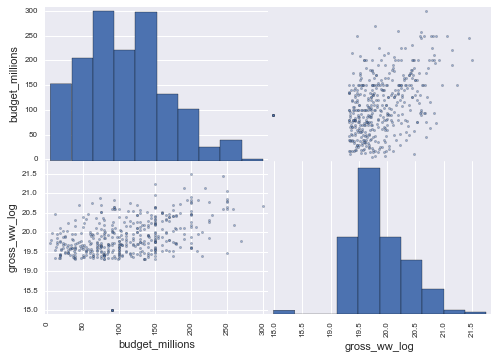

In [20]:
pd.tools.plotting.scatter_matrix(new_movies_df)

## Regression Results

In [21]:
y, X = dmatrices('gross_ww_log ~ budget_millions + genre + rating', data=movies_df, return_type='dataframe')

In [22]:
X.head()

,Intercept,genre[T.Action / Adventure],genre[T.Action Comedy],genre[T.Action Drama],genre[T.Action Fantasy],genre[T.Action Horror],genre[T.Action Thriller],genre[T.Adventure],genre[T.Adventure Comedy],genre[T.Animation],...,genre[T.Sports Drama],genre[T.Thriller],genre[T.War],genre[T.War Drama],genre[T.Western],rating[T.PG],rating[T.PG-13],rating[T.R],rating[T.Unrated],budget_millions
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,90.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,200.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,245.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,150.0
5,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,220.0


In [23]:
sum(X['genre[T.Adventure Comedy]'])

0.0

In [24]:
len(X.columns)

55

In [25]:
y.head()

,gross_ww_log
0,17.991760
2,21.505692
3,21.449956
4,21.236329
5,21.141685


In [27]:
model = sm.OLS(y, X)
results = model.fit()

In [28]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           gross_ww_log   R-squared:                       0.435
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     5.904
Date:                Thu, 29 Sep 2016   Prob (F-statistic):           3.15e-25
Time:                        16:34:36   Log-Likelihood:                -175.54
No. Observations:                 435   AIC:                             453.1
Df Residuals:                     384   BIC:                             660.9
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
Intercept                      19.4096      0.142    136.482      0.000        19.130    19.689
genre[T.Action / Adventure]     0.0465      0.087      0.535      0.593        -0.124     0.217
genre[T.Action Comedy]         -0.2945      0.141     -2.095      0.037        -0.571    -0.018
genre[T.Action Drama]           0.0311      0.172      0.181      0.856        -0.307     0.369
genre[T.Action Fantasy]     -6.912e-14   1.46e-14     -4.748      0.000     -9.77e-14 -4.05e-14
genre[T.Action Horror]         -0.1187      0.281     -0.422      0.673        -0.672     0.435
genre[T.Action Thriller]       -0.1491      0.147     -1.016      0.310        -0.438     0.140
genre[T.Adventure]              0.0355      0.161      0.221      0.825        -0.281     0.352
genre[T.Adventure Comedy]   -6.305e-15   3.02e-15     -2.088      0.037     -1.22e-14 -3.68e-16
genre[T.Animation]              0.1804      0.116      1.556      0.120        -0.048     0.408
genre[T.Comedy]                -0.1273      0.109     -1.168      0.244        -0.342     0.087
genre[T.Comedy / Drama]         0.1011      0.234      0.431      0.667        -0.360     0.562
genre[T.Concert]            -1.311e-15   4.58e-15     -0.286      0.775     -1.03e-14   7.7e-15
genre[T.Crime Comedy]          -0.0312      0.281     -0.111      0.912        -0.584     0.522
genre[T.Crime Drama]           -0.3896      0.285     -1.367      0.173        -0.950     0.171
genre[T.Drama]                 -0.1324      0.133     -0.996      0.320        -0.394     0.129
genre[T.Drama / Thriller]       0.0224      0.396      0.057      0.955        -0.756     0.801
genre[T.Family]                -0.1574      0.400     -0.394      0.694        -0.944     0.629
genre[T.Family Adventure]      -0.1361      0.161     -0.843      0.400        -0.454     0.181
genre[T.Family Comedy]          0.1220      0.162      0.752      0.453        -0.197     0.441
genre[T.Fantasy]                0.2670      0.118      2.265      0.024         0.035     0.499
genre[T.Fantasy Comedy]         0.0341      0.235      0.145      0.885        -0.428     0.496
genre[T.Fantasy Drama]         -0.0646      0.281     -0.230      0.818        -0.617     0.488
genre[T.Foreign]            -3.722e-17   2.54e-16     -0.146      0.884     -5.37e-16  4.63e-16
genre[T.Historical Drama]       0.1725      0.236      0.730      0.466        -0.292     0.637
genre[T.Historical Epic]        0.0210      0.286      0.073      0.941        -0.541     0.583
genre[T.Horror]                -0.0412      0.188     -0.220      0.826        -0.410     0.328
genre[T.Horror Comedy]         -0.3037      0.235     -1.293      0.197        -0.766     0.158
genre[T.Horror Thriller]        0.4731      0.401      1.179      0.239        -0.316     1.262
genre[T.Mus

# LassoCV Regression

### imports

In [29]:
import sklearn
from sklearn.cross_validation import KFold, cross_val_score
import sklearn.cross_validation as cv
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn import metrics
from sklearn.preprocessing import normalize

### lasso formula (train & test)

In [44]:
y, X = dmatrices('gross_ww_log ~ budget_millions + genre + rating', data=movies_df, return_type='dataframe')
X = normalize(X, axis=0)
x_train, x_test, y_train, y_test = cv.train_test_split(X, y, test_size=0.20, random_state=1234)
model_lasso1 = sklearn.linear_model.LassoCV(eps=0.001, n_alphas=100, cv=10).fit(x_train, sklearn.utils.column_or_1d(y_train))

print 'X train MSE: ',(sklearn.metrics.mean_squared_error(y_train, model_lasso1.predict(x_train)))
print 'X test MSE: ',(sklearn.metrics.mean_squared_error(y_test, model_lasso1.predict(x_test)))

print'alpha =', model_lasso1.alpha_
m_alphas = model_lasso1.alphas_

X train MSE:  0.133459747906
X test MSE:  0.146652316896
alpha = 0.000547619453713


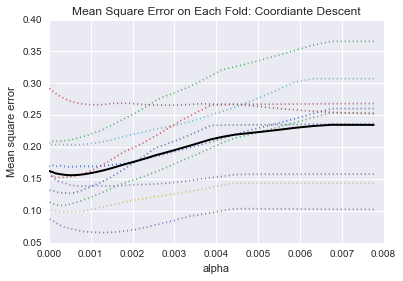

In [45]:
plt.pyplot.plot(m_alphas, model_lasso1.mse_path_, ':')
plt.pyplot.xlabel('alpha')
plt.pyplot.ylabel('Mean square error')
plt.pyplot.title('Mean Square Error on Each Fold: Coordiante Descent')
plt.pyplot.plot(m_alphas, model_lasso1.mse_path_.mean(axis=-1), 'k', label='Average Across The Folds', linewidth=2)
#plt.pyplot.ylim(ymin=.12e17,ymax=.25e17);